# GoFast - сервис аренды электросамокатов. В данном проекте мы поработаем над данными о пользователях этого сервиса. Проведем исследовательский и статистический анализы, проверим некоторые гипотезы касаемо пользователей, которые потенциально могут помочь бизнесу вырасти. Например, гипотезу о том, влияет ли на выручку компании наличие у пользователя платной подписки на сервис.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp

#### Шаг 1. Загрузка данных

##### Загрузим данные и просмотрим их

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В датафрейме users по видимому хранятся индивидуальные данные пользователя (айдишник, имя, возраст, город проживания) и информация о типе подписки. 

In [4]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В датафрейме rides к айдишникам пользователей из датафрейма users прикручены данные о поездках. Такие, как дистанция поездки, время и дата. 

In [5]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В датафрейме subs хранится общая информация о тарификации подписки / бесплатного использования. 

Прошу заметить что пропусков не наблюдается. 

In [6]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


Все как и упоминалось выше. Имеем айди, имя, возраст, город и тип подписки. 

In [7]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Здесь мы можем заметить что к одному и тому же айди прикручено сразу несколько поездок. 

In [8]:
subs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Условия тарифов :)

##### Изучим типы данных

In [9]:
users.dtypes

user_id               int64
name                 object
age                   int64
city                 object
subscription_type    object
dtype: object

Видим айдишники типа инт, возраст так же инт, все остальные у нас объекты

In [10]:
rides.dtypes

user_id       int64
distance    float64
duration    float64
date         object
dtype: object

Видим те же самые айдишники, однако одному айди у нас привязано несколько поездок, дистанция и длительность это флоаты и дата типа object

In [11]:
subs.dtypes

subscription_type    object
minute_price          int64
start_ride_price      int64
subscription_fee      int64
dtype: object

тип подписки все так же объект, все остальное - инт

#### Шаг 2. Предобработка данных

##### Переведем столбец date во фрейме rides из object к специальному типу datetime

In [12]:
rides['date'] = pd.to_datetime(rides['date'])

In [13]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [14]:
rides.dtypes

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

##### Создадим столбец с номером месяца на основе столбца date

In [15]:
rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [16]:
rides['date'].max()

Timestamp('2021-12-30 00:00:00')

Как мы можем увидеть, данные о поездах у нас исключительно за 2021 год. С 01.01 по 30.12

In [17]:
rides['month'] = rides['date'].dt.month

In [18]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [19]:
rides.dtypes

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
month                int64
dtype: object

##### Изучим дубликаты

In [20]:
duplicate_counts_users = users.apply(lambda x: x.duplicated().sum())
print(duplicate_counts_users)

user_id                31
name                 1371
age                  1536
city                 1557
subscription_type    1563
dtype: int64


In [21]:
duplicate_counts_rides = rides.apply(lambda x: x.duplicated().sum())
print(duplicate_counts_rides)

user_id     16534
distance        0
duration       94
date        17704
month       18056
dtype: int64


In [22]:
duplicate_counts_subs = subs.apply(lambda x: x.duplicated().sum())
print(duplicate_counts_subs)

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Как мы можем заметить дубликаты которые нужно обрабатывать находятся только в таблице users, у нас не должно быть в списке юзеров одинаковых юзеров, они должны быть уникальными. Во всех остальных таблицах, да и столбцах таблицы users, дубликаты очень даже приветствуются. 

In [23]:
users = users.drop_duplicates(subset='user_id')

In [24]:
duplicate_counts_users = users.apply(lambda x: x.duplicated().sum())
print(duplicate_counts_users)

user_id                 0
name                 1340
age                  1505
city                 1526
subscription_type    1532
dtype: int64


Итогом проделанной работы имеем то, что разных пользователей с одним и тем же уникальным айди нет. То, что имена, города и так далее повторяются - это НОРМА. 

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

Text(0.5, 1.0, 'Статистика встречаемости городов')

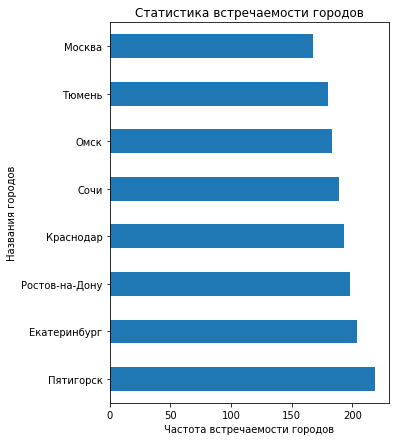

In [25]:
users['city'].value_counts().sort_values(ascending=False).plot(kind='barh', figsize=(5, 7), ylabel='Названия городов')
plt.xlabel('Частота встречаемости городов')
plt.title('Статистика встречаемости городов')

Как мы можем заметить, чаще всего встречается город Пятигорск, меньше всего - Москва

##### Соотношение пользователей с подпиской и без подписки

Text(0.5, 1.0, 'Процентное соотношение пользователей с разными видами подписок')

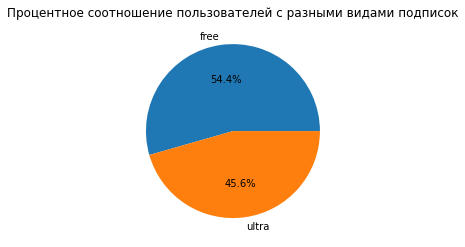

In [26]:
users['subscription_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', ylabel='')
plt.title('Процентное соотношение пользователей с разными видами подписок')

Как можем заметить бесплатных подписчиков больше, однако разница не такая уж и большая

##### Возраст пользователей

Text(0, 0.5, 'Количество пользователей')

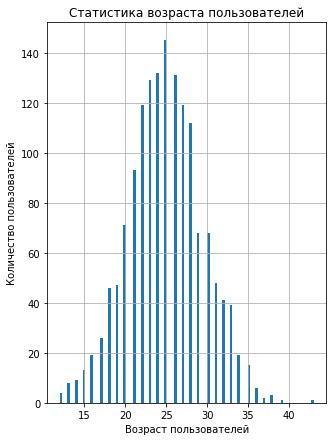

In [27]:
users['age'].hist(bins=100, figsize=(5, 7))
plt.title('Статистика возраста пользователей')
plt.xlabel('Возраст пользователей')
plt.ylabel('Количество пользователей')

In [28]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Как можно увидеть из этой гистограммы и данных из метода describe(), большинство пользователей - молодые люди от 20 до 30 лет

##### Расстояние, которое пользователь преодолел за одну поездку

Text(0, 0.5, 'Количество поездок')

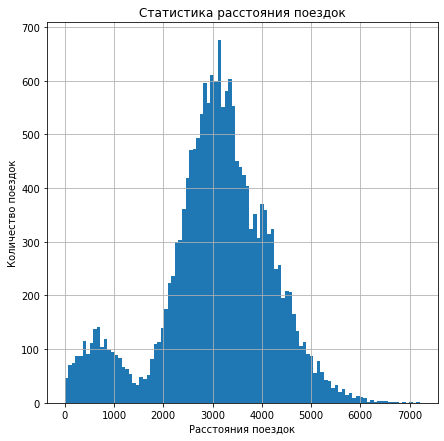

In [29]:
rides['distance'].hist(bins=100, figsize=(7, 7))
plt.title('Статистика расстояния поездок')
plt.xlabel('Расстояния поездок')
plt.ylabel('Количество поездок')

В основном поездки длиной от 2.5 до 4 км, большинство - порядка 3 км

Два пиковых значения можно объяснить тем, что кто-то условно экономит время и деньги на такси, так как есть пробки. А кто-то берет например сгонять в магазин, либо, как я очень часто видел в МСК, подростки берут самокаты просто погонять по парку недолго. 

##### Продолжительность поездок

Text(0, 0.5, 'Количество поездок данной продолжительности')

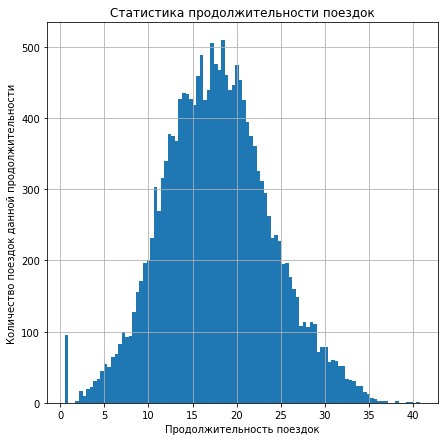

In [30]:
rides['duration'].hist(bins=100, figsize=(7, 7))
plt.title('Статистика продолжительности поездок')
plt.xlabel('Продолжительность поездок')
plt.ylabel('Количество поездок данной продолжительности')

В основном поездки занимают 15-20 минут +- несколько минут с каждой стороны

#### Шаг 4. Объединение данных

##### Объединим данные трех датафреймов

In [31]:
merged_df = pd.merge(rides, users, on='user_id', how='left')
final_df = pd.merge(merged_df, subs, on='subscription_type', how='left')

На данном этапе мы в два действия соединили все три датафрейма в один. Сначала таблицу о поездках с таблицей о пользователях. Далее получившуюся таблицу с данными о тарифах. 

In [32]:
final_df.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [33]:
rides.shape

(18068, 5)

In [34]:
merged_df.shape

(18068, 9)

In [35]:
final_df.shape

(18068, 12)

Ничего не потеряли и не добавили

##### Разобъем полученный датафрейм на два, которые отличаются по типу подписки пользователя

In [36]:
free_users_df = final_df[final_df['subscription_type'] == 'free']
ultra_users_df = final_df[final_df['subscription_type'] == 'ultra']

In [37]:
free_users_df.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [38]:
ultra_users_df.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


##### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

###### Для бесплатных

Text(0, 0.5, 'Количество поездок заданной длины')

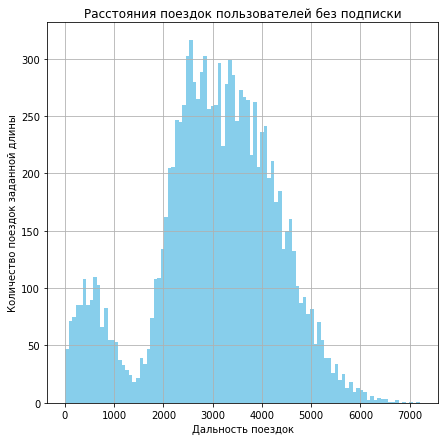

In [39]:
free_users_df['distance'].hist(bins=100, color='skyblue', figsize=(7, 7))
plt.title('Расстояния поездок пользователей без подписки')
plt.xlabel('Дальность поездок')
plt.ylabel('Количество поездок заданной длины')

Text(0, 0.5, 'Количество поездок с заданным временем')

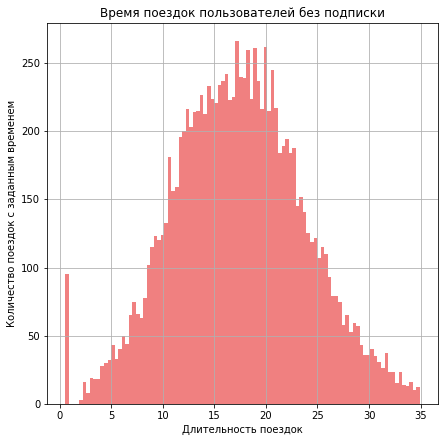

In [40]:
free_users_df['duration'].hist(bins=100, color='lightcoral', figsize=(7, 7))
plt.title('Время поездок пользователей без подписки')
plt.xlabel('Длительность поездок')
plt.ylabel('Количество поездок с заданным временем')

Как мы можем увидеть по двум графикам, средняя дистанция на бесплатном 2-4 км, а время 15-20 минут

###### Для подписчиков

Text(0, 0.5, 'Количество поездок с заданным расстоянием')

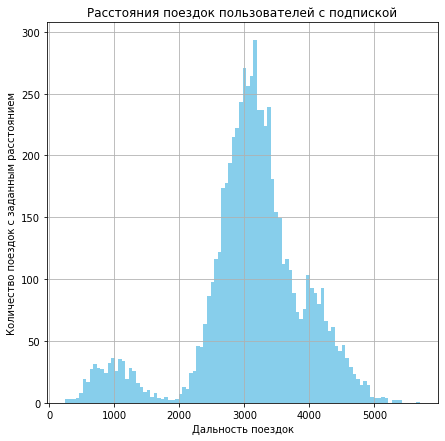

In [41]:
ultra_users_df['distance'].hist(bins=100, color='skyblue', figsize=(7, 7))
plt.title('Расстояния поездок пользователей с подпиской')
plt.xlabel('Дальность поездок')
plt.ylabel('Количество поездок с заданным расстоянием')

Text(0, 0.5, 'Количество поездок с заданным временем')

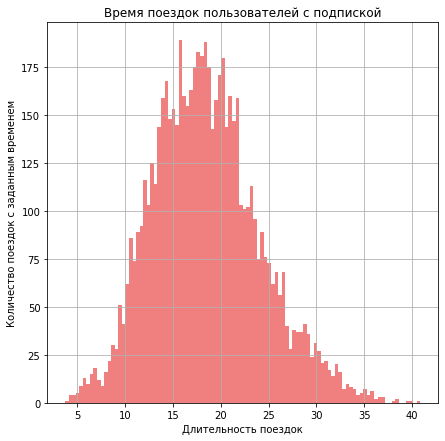

In [42]:
ultra_users_df['duration'].hist(bins=100, color='lightcoral', figsize=(7, 7))
plt.title('Время поездок пользователей с подпиской')
plt.xlabel('Длительность поездок')
plt.ylabel('Количество поездок с заданным временем')

Как мы можем увидеть, подписчики преодолевают расстояние близкое к 3-м километрам с обеих сторон. А по времени это все те же 15-20 мин

#### Шаг 5. Подсчёт выручки

##### Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4

In [43]:
final_df['duration'] = np.ceil(final_df['duration']) 

In [44]:
grouped = final_df.groupby(['user_id', 'month'])

agg_data = grouped.agg({
    'distance': 'sum',
    'duration': 'sum',
    'user_id': 'count',
    'minute_price': 'first',
    'start_ride_price': 'first',
    'subscription_fee': 'first'
})
agg_data.rename(columns={'user_id': 'rides_amount'}, inplace=True)
agg_data['monthly_revenue'] = agg_data['start_ride_price'] * agg_data['rides_amount'] + \
                              agg_data['minute_price'] * agg_data['duration'] + \
                              agg_data['subscription_fee']

In [45]:
agg_data['subscription_type'] = agg_data['subscription_fee'].apply(lambda x: 'ultra' if x == 199 else 'free')

In [46]:
agg_data.head(20)

distance  duration  rides_amount  minute_price  \
user_id month                                                       
1       1       7027.511294      42.0             2             6   
        4        754.159807       7.0             1             6   
        8       6723.470560      46.0             2             6   
        10      5809.911100      32.0             2             6   
        11      7003.499363      56.0             3             6   
        12      6751.629942      28.0             2             6   
2       3      10187.723006      63.0             3             6   
        4       6164.381824      40.0             2             6   
        6       3255.338202      14.0             1             6   
        7       6780.722964      48.0             2             6   
        8        923.007439       7.0             1             6   
        10      2824.636598      19.0             1             6   
        12      3828.248580      12.0             1             6   
3       1       3061.777147      13.0             1             6   
        2       5421.152016      39.0             2             6   
        4       2956.651632      21.0             1             6   
        5       9064.026918      63.0             3             6   
        7      10919.595403      67.0             3             6   
        9       2891.012822      23.0             1             6   
        12      2593.381928      13.0             1             6   

               start_ride_price  subscription_fee  monthly_revenue  \
user_id month                                                        
1       1                     0               199            451.0   
        4                     0               199            241.0   
        8                     0               199            475.0   
        10                    0               199            391.0   
        11                    0               199            535.0   
        12                    0               199            367.0   
2       3                     0               199            577.0   
        4                     0               199            439.0   
        6                     0               199            283.0   
        7                     0               199            487.0   
        8                     0               199            241.0   
        10                    0               199            313.0   
        12                    0               199            271.0   
3       1                     0               199            277.0   
        2                     0               199            433.0   
        4                     0               199            325.0   
        5                     0               199            577.0   
        7                     0               199            601.0   
        9                     0               199            337.0   
        12                    0               199            277.0   

              subscription_type  
user_id month                    
1       1                 ultra  
        4                 ultra  
        8                 ultra  
        10                ultra  
        11                ultra  
        12                ultra  
2       3                 ultra  
        4                 ultra  
        6                 ultra  
        7                 ultra  
        8                 ultra  
        10                ultra  
        12                ultra  
3       1                 ultra  
        2                 ultra  
        4                 ultra  
        5                 ultra  
        7                 ultra  
        9                 ultra  
        12                ultra

#### Шаг 6. Проверка гипотез

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки?

H0: Среднее время поездки подписчиков <= среднему времени поездки бесплатных пользователей.
H1: Среднее время поездки подписчиков > среднего времени поездки бесплатных пользователей.

In [47]:
ultra_users_df['duration'].mean()

18.54198516280583

In [48]:
free_users_df['duration'].mean()

17.39090929866399

In [49]:
alpha = 0.05


test = ttest_ind(ultra_users_df['duration'], free_users_df['duration'], alternative='greater')


test.pvalue < alpha

True

Отклоняем H0. Значит среднее время поездки подписчиков статистически значимо больше среднего времени поездки бесплатных пользователей.

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

H0: Среднее расстояние поездки подписчиков <= 3130. H1: Среднее расстояние поездки подписчиков > 3130. 

In [50]:
alpha = 0.05

optimal_distance = 3130

test1 = ttest_1samp(ultra_users_df['distance'], optimal_distance, alternative='greater')

test1.pvalue < alpha

False

Мы НЕ отклоняем нулевую гипотезу. Значит подписчики действительно в среднем проезжают менее 3130 метров за поездку. 

##### Гипотеза о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

H0: Средняя помесячная выручка от пользователей с подпиской не выше средней помесячной выручки от бесплатных пользователей.
H1: Средняя помесячная выручка от пользователей с подпиской выше средней помесячной выручки от бесплатных пользователей.

In [51]:
subscription_revenue = agg_data[agg_data['subscription_fee'] == 199]['monthly_revenue']
free_revenue = agg_data[agg_data['subscription_fee'] == 0]['monthly_revenue']

In [52]:
alpha = 0.05

test2 = ttest_ind(subscription_revenue, free_revenue, alternative='greater')

test2.pvalue < alpha

True

Значит, мы отвергаем нулевую гипотезу. И все же средняя помесячная выручка от пользователей с подпиской выше средней помесячной выручки от бесплатных пользователей.

##### Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Однозначно будет использоваться scipy.stats.ttest_rel(), так как мы анализируем одну генеральную совокупность, с которой произошли некоторые изменения. 

Calculate the t-test on TWO RELATED samples of scores, a and b.

This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

# ВЫВОДЫ

## Таким образом, предметом нашего исследования стали пользователи приложения аренды самокатов GoFast. Методами статистического и исследовательского анализов данных мы в первую очередь навели порядок в данных во избежании коллизий. Далее предметно рассмотрели базовую статистическую информацию о пользователях. Например, распределение городов и возрастов. Так же мы выясняли отличия двух групп пользователей, с подпиской и без, само собой так же проверяя статистически параметры о поездках и так далее. И самое важное, мы проверяли различные гипотезы об этих двух группах пользователей. В первую очередь, определяя разницу между доходом для бизнеса в зависимости от наличия подписки на сервис, а так же влияние на износ самокатов. 
## Да, подписчики сервиса действительно статистически выгодны для бизнеса. Хоть они и проводят "за рулем" больше времени, однако они все равно не наносят дополнительный вред транспорту, так как проезжают оптимальное для самоката расстояние. И, конечно же, как ни крути, но статистика показала, что выручка от подписчиков больше. Значит, пользователи с подпиской более выгодны. 
## По сути, дубликаты нам совершенно не страшны, только если это не абсолютно разные пользователи с одинаковыми УНИКАЛЬНЫМИ айдишниками. Я считаю, что важным признаком прогнозирования может стать например месяц года, так как самокат не очень то и зимний вид транспорта (если, конечно, речь идет про это). Так же было бы неплохо как-то помечать наличие популярного маршрута у пользователя (и, возможно, сам маршрут, либо просто популярные точки у пользователя), но, кажется, это уже по части МЛщиков. Пропуски тоже зависят от критерия, но, например, если есть пропуск в duration или distance, фича с популярными маршрутами может легко заделать эту дыру. Если в данных будет флаг, который отвечает за принадлежность поездки к частому маршруту. Вероятно, он не будет сильно отличаться от предыдущих таких же. 